# I - Kriging

The aim of this practical session is to manipulate the kriging utilities from the *gstlearn* package.

## I.1 - Load Packages and data

In [1]:
import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp

## Figure sizes
plt.rcParams['figure.figsize'] = [8,6]


We start by loading the data.

In [2]:
## Dataset
jura_all=pd.read_csv("jura/jura_pred.csv")

Separate the data set in two sets : the training set and the validation set.
For the project and the Kaggle competition, you should use the full data set for 
the training.
You will submit your prediction on Kaggle for a set of locations on which you will 
only know the locations and the factors of Land Use and Rock at these locations.

In [3]:
## Separation Training/Validation data
ntot = jura_all.shape[0]
ntrain = 200 ## Number of training samples
nval = ntot - ntrain
rd.seed(1)
indtrain = rd.sample(range(ntot),ntrain) ## Indices of training samples
indval = np.setdiff1d(np.arange(ntot),indtrain) ## Indices of validation samples

## Training dataset
jura =jura_all.loc[indtrain,:]

## Location of the validation points
val_loc =jura_all.loc[indval,['Xloc','Yloc','Landuse','Rock']]

## Response variable (Cobalt concentration) at the validation locations
val=jura_all.loc[indval,['Co']]

## I.2 - Simple kriging : Do it yourself

In this section, we compute manually a simple kriging prediction of the Cobalt concentrations on a target grid.

We first load the coordinates of a target grid on which we will predict the Cobalt concentrations.

In [4]:
## Load target grid locations
grid=pd.read_csv("./jura/square_grid_loc.csv")

## Function to plot a variable on a grid
def plot_grid(ax,z,grid):
       Nx=len(np.unique(grid['Xloc']))
       Ny=len(np.unique(grid['Yloc']))
       im=ax.imshow(np.array(z).reshape(Ny,Nx)[np.flip(range(Ny)),:],
           extent=[grid['Xloc'].min(),grid['Xloc'].max(),grid['Yloc'].min(),grid['Yloc'].max()])
       return im

We start by fitting an exponential covariance model to the data using the same approach as in the previous practical session.

In [5]:
## Convert Pandas dataframe containing the training data into gstlearn Db
db_jura=gl.Db_fromPanda(jura)

## Set locators for coordinates and variable of interest
db_jura.setLocators(['Xloc','Yloc'],gl.ELoc.X)
db_jura.setLocators(['Co'],gl.ELoc.Z)

## Create experimental variogram
varioParamOmni = gl.VarioParam.createOmniDirection(npas=30, dpas=0.1, toldis=0.5)
varioexp = gl.Vario(varioParamOmni)
err = varioexp.compute(db_jura)

## Fit experimental variogram with an exponential covariance
fitmod = gl.Model()
types = [gl.ECov.EXPONENTIAL]
err = fitmod.fit(varioexp,types=types)
fitmod.display()


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
Exponential
- Sill         =     13.314
- Range        =      1.201
- Theo. Range  =      0.401
Total Sill     =     13.314
Known Mean(s)     0.000


We then extract the sill and scale (also called "Theroretical range") parameters from the fitted model.

In [10]:
## Extract
sill_fit=fitmod.getCova(0).getSill(0,0)
scale_fit=fitmod.getCova(0).getScale(0)

## Print
print("sill =",sill_fit)
print("scale =",scale_fit)

sill = 13.31441263438875
scale = 0.40092948816563256


**Create a function that evaluates an exponential covariance model at a given lag h, with the sill and scale parameters fitted above.**

In [11]:
## Inputs:
##### h : Lag value (or vector)
## Output
##### Value of the exponential covariance model (with scale and sill defined above) at lag h : C(h)= sill * exp(-h/scale)

def Cexp(h):
  return sill_fit*np.exp(-h/scale_fit)

We will now implement the simple kriging prediction and the kriging error standard deviation (on a unique neighborhood) to estimate the concentration of Cobalt on the points defined in the target grid `grid`, using the data in the data frame `jura`.


**Compute the mean of the Cobalt observations (which we will use as the simple kriging mean).**

In [12]:
mean_Co=jura['Co'].mean()
mean_Co

np.float64(9.19706)

**Build the matrix of covariance values between the pairs of data points  (Size : Number of data points x Number of data points). (Hint: Use the function `np.subtract.outer` to efficiently compute distance matrices)**

In [13]:
## Compute matrix of distances between the pairs of points
dist_data = (np.subtract.outer(jura['Xloc'].to_numpy(),jura['Xloc'].to_numpy())**2
             +np.subtract.outer(jura['Yloc'].to_numpy(),jura['Yloc'].to_numpy())**2)**0.5

## Compute matrix of covariances between the pairs of points using dist_dat and Cexp
cov_data=Cexp(dist_data)


**Compute the matrix of covariance values between the target points and the data points (Size : Number of target points x Number of data points)**

In [ ]:
## Compute matrix of distances between the data points and the target points
dist_tar = (np.subtract.outer(grid['Xloc'].to_numpy(),jura['Xloc'].to_numpy())**2 +
            np.subtract.outer(grid['Yloc'].to_numpy(),jura['Yloc'].to_numpy())**2)**0.5

## Compute matrix of covariances between the pairs of points
cov_tar=Cexp(dist_tar)


**Extract the values of Cobalt concentrations into a vector**

In [15]:
values_Co=jura['Co'].to_numpy()

**Compute the simple kriging predictor (Hint: Use `np.linalg.solve` to solve a linear system and `np.matmul` for matrix products)**

In [ ]:
## Compute the kriging predictor
SK_Co_pred_grid=mean_Co+np.matmul(cov_tar,np.linalg.solve(cov_data,values_Co-mean_Co))

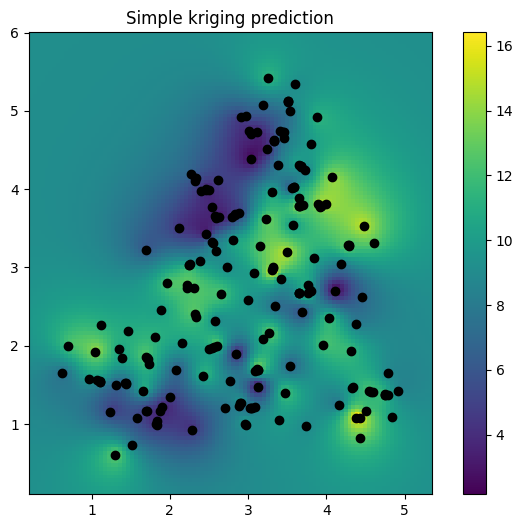

In [17]:
## Plot results
fig,ax=plt.subplots()
im=plot_grid(ax,SK_Co_pred_grid,grid)
ax.scatter(jura['Xloc'],jura['Yloc'],color='black')
ax.set_title("Simple kriging prediction")
fig.colorbar(im)
plt.show()

**Compute the simple kriging variance (Hint: Use the method `transpose()` to transpose a matrix and `np.diag` to extract the diagonal elements of a matrix)**

In [28]:
SK_Co_var_grid=np.diag(sill_fit-np.matmul(cov_tar,np.linalg.solve(cov_data,cov_tar.transpose())))
SK_Co_pred_grid

array([9.30933239, 9.32885445, 9.35122847, ..., 9.24591992, 9.24231929,
       9.23893675])

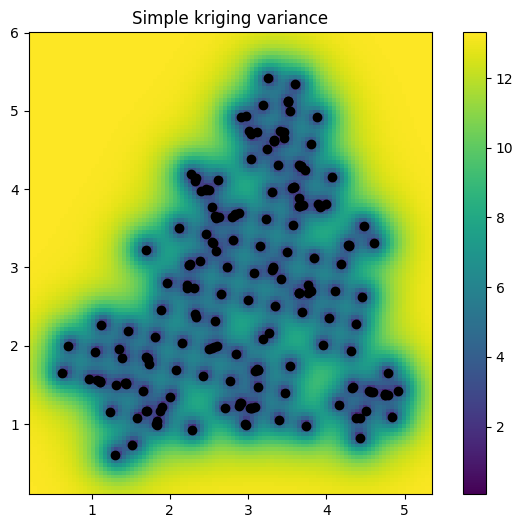

In [29]:
## Plot results
fig,ax=plt.subplots()
im=plot_grid(ax,SK_Co_var_grid,grid)
ax.scatter(jura['Xloc'],jura['Yloc'],color='black')
ax.set_title("Simple kriging variance")
fig.colorbar(im)
plt.show()

**Compute the simple kriging prediction and variance at the validation locations (in the dataframe `val_loc`)**

In [ ]:
## Compute matrix of distances between the data points and the validation points
dist_val = (np.subtract.outer(val_loc['Xloc'].to_numpy(),jura['Xloc'].to_numpy())**2+
            np.subtract.outer(val_loc['Yloc'].to_numpy(),jura['Yloc'].to_numpy())**2)**0.5

## Compute matrix of covariances
cov_val=Cexp(dist_val)

## Simple kriging prediction
SK_Co_pred_val=mean_Co+np.matmul(cov_val,np.linalg.solve(cov_data,values_Co-mean_Co))

## Simple kriging variance
SK_Co_var_val=np.diag(sill_fit-np.matmul(cov_val,np.linalg.solve(cov_data,cov_val.transpose())))


**Compute the resulting RMSE and MAPE.**

In [31]:

## RMSE
print("RMSE=",np.mean((SK_Co_pred_val-val['Co'])**2)**0.5)

## MAPE
print("MAPE=",np.mean(abs((SK_Co_pred_val-val['Co'])/val['Co'])))


RMSE= 2.3463061122344953
MAPE= 0.2351819572791696


## I.3 - Kriging using gstlearn

We know use gstlearn to perform kriging.

First, we create a gstlearn database containing the data points, and assign the appropriate locators to the variables.

In [32]:
## Create Db containing the training data
db_jura=gl.Db_fromPanda(jura)

## Set locators
db_jura.setLocators(['Xloc','Yloc'],gl.ELoc.X) # -> Role = Coordinates
db_jura.setLocators(['Co'],gl.ELoc.Z) # -> Role  = Variable of interest

## Display content
db_jura.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 11
Total number of samples      = 200

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Landuse - Locator = NA
Column = 3 - Name = Rock - Locator = NA
Column = 4 - Name = Cd - Locator = NA
Column = 5 - Name = Co - Locator = z1
Column = 6 - Name = Cr - Locator = NA
Column = 7 - Name = Cu - Locator = NA
Column = 8 - Name = Ni - Locator = NA
Column = 9 - Name = Pb - Locator = NA
Column = 10 - Name = Zn - Locator = NA


We also create a gstlearn *Grid Database* containing the target grid for the prediction.

In [33]:
## Create DbGrid that covers the Db containing the data
db_grid=gl.DbGrid.createCoveringDb(db_jura,dx=[0.05,0.05],margin=[0.2,0.2])
db_grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 2
Total number of samples      = 9975

Grid characteristics:
---------------------
Origin :      0.426     0.399
Mesh   :      0.050     0.050
Number :         95       105

Variables
---------
Column = 0 - Name = x1 - Locator = x1
Column = 1 - Name = x2 - Locator = x2


Finally, we create a Db containing the validation locations and the value of Cobalt concentrations at those locations.

In [34]:
## Create Db
db_val=gl.Db_fromPanda(val_loc)

## Set locators
db_val.setLocators(['Xloc','Yloc'],gl.ELoc.X) # -> Role = Coordinates

## Add Co values
db_val["Co"]=val

## Display content
db_val.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 5
Total number of samples      = 59

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Landuse - Locator = NA
Column = 3 - Name = Rock - Locator = NA
Column = 4 - Name = Co - Locator = NA


### 1 - Simple kriging

To perform simple kriging, we use the function called kriging. We specify:

- the Db object containing the data points (argument dbin) : the variable used for kriging is the (unique) variable of the data base with a z locator (i.e. it should have locator z1 and the other variables should not have a locator starting with z)
- the Db object containing the target points, i.e. the points where the kriging predictor will be computed (argument dbout)
- the Model object containing the model used to define the kriging predictor (argument model): in particular, the mean used to define the predictor is the one set in the Model object
- the type of neighborhood used in the prediction (argument neigh), eg. unique neighborhood (to use all the data points for each predictor) or moving neighborhood (to use only the data points in the vicinity of the target point in the prediction). This argument is defined using a "neighborhood" object (see example below).

Additionally, it is possible to specify whether we wish to compute, at each target point, the kriging predictor (argument flag_est, default=TRUE), the kriging standard-deviation (argument flag_std, default=TRUE) and the kriging variance (argument flag_varz, default=FALSE).

The kriging function then adds new variables to the Db entered in the dbout argument corresponding to these variables. The names of these newly created variables will start by Kriging, but this prefix can be changed using the namconv argument of the kriging function.

Hence, to perform a simple kriging prediction using *gstlearn* we can follow these steps:

1. Specify, in the Db containing the data, the variable that you want to predict by assigning the locator 'z' to that variable (only)

In [35]:
db_jura.setLocators(['Co'],gl.ELoc.Z,cleanSameLocator=True)
db_jura.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 11
Total number of samples      = 200

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Landuse - Locator = NA
Column = 3 - Name = Rock - Locator = NA
Column = 4 - Name = Cd - Locator = NA
Column = 5 - Name = Co - Locator = z1
Column = 6 - Name = Cr - Locator = NA
Column = 7 - Name = Cu - Locator = NA
Column = 8 - Name = Ni - Locator = NA
Column = 9 - Name = Pb - Locator = NA
Column = 10 - Name = Zn - Locator = NA


2. Define the type of neighborhood you want to use for the kriging. For instance, for a unique neighborhood: 

In [36]:
## For a unique neighborhood
uniqueNeigh = gl.NeighUnique.create()

3. Define the covariance model and mean used for simple kriging: the mean used in the simple kriging predictor is the one set in the Model object supplied in the kriging function.

In [37]:
## Copy the covariance model previously fitted on the data 
model_SK=gl.Model(fitmod)
## Set the mean
model_SK.setMean(mean=mean_Co)

4. Call the `kriging` function using the Db, Model and Neighborhood defined earlier.

In [38]:
## Remove variables starting with a given prefix (-> Results from previous runs)
db_grid.deleteColumns(["SK*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_grid, model=model_SK, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False, ## To compute the predictor and its standard-deviation, but not its variance
              namconv=gl.NamingConvention("SK") ## Prefix that will be used to identify the results in the output database
              )


We see that the kriging predictor and its standard deviation have been added to the grid data base.

In [40]:
## Display database
db_grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 9975

Grid characteristics:
---------------------
Origin :      0.426     0.399
Mesh   :      0.050     0.050
Number :         95       105

Variables
---------
Column = 0 - Name = x1 - Locator = x1
Column = 1 - Name = x2 - Locator = x2
Column = 2 - Name = SK.Co.estim - Locator = z1
Column = 3 - Name = SK.Co.stdev - Locator = NA


We can then plot the results.

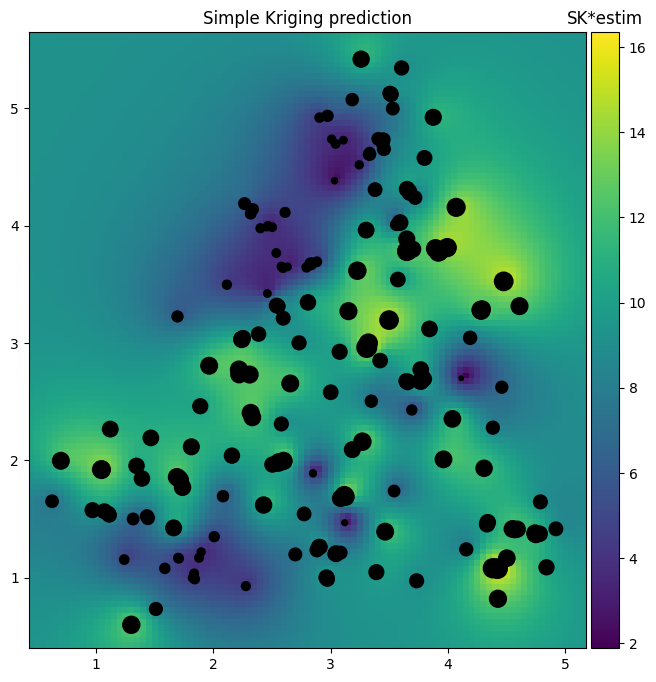

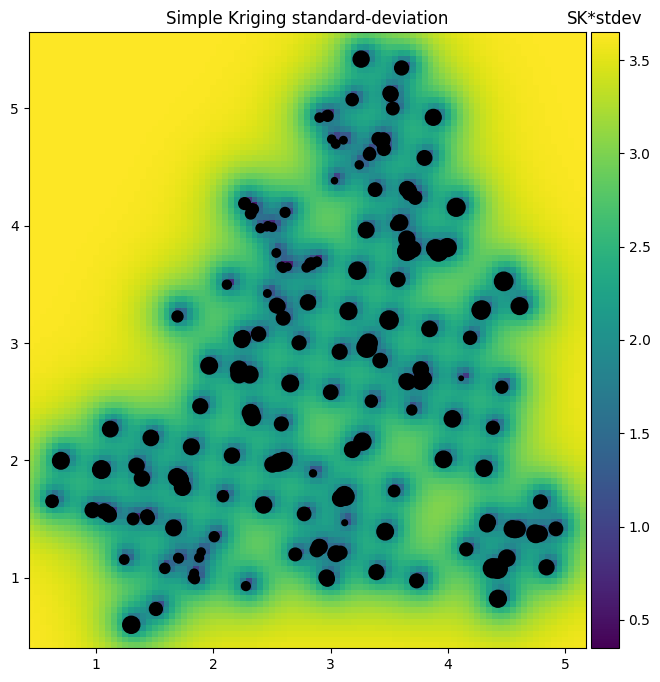

In [41]:
## Plot prediction
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="SK*estim",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Simple Kriging prediction")
plt.show()

## Plot kriging standard-deviation
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="SK*stdev",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Simple Kriging standard-deviation")
plt.show()

**Compute the simple kriging prediction and standard-deviation at the validation locations (instead of the target grid), and compute the resulting RMSE and MAPE. (Hint: Use the prefix "SK" to store the results)**

In [42]:
## Remove variables starting with a given prefix (-> Results from previous runs)
db_val.deleteColumns(["SK*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_val, model=model_SK, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False, ## To compute the predictor and its standard-deviation, but not its variance
              namconv=gl.NamingConvention("SK") ## Prefix that will be used to identify the results in the output database
              )

db_val.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 7
Total number of samples      = 59

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Landuse - Locator = NA
Column = 3 - Name = Rock - Locator = NA
Column = 4 - Name = Co - Locator = NA
Column = 5 - Name = SK.Co.estim - Locator = z1
Column = 6 - Name = SK.Co.stdev - Locator = NA


In [43]:
## Compute RMSE
rmse_SK=np.mean((db_val["Co"]-db_val["SK*estim"])**2)**0.5
print("RMSE=",rmse_SK)

## Compute MAPE
mape_SK=np.mean(abs((db_val["Co"]-db_val["SK*estim"])/db_val["Co"]))
print("MAPE=",mape_SK)

RMSE= 2.3463061122345037
MAPE= 0.2351819572791715


### 2 - Ordinary kriging

In gstlearn, ordinary kriging is seen as the formulation of a kriging predictor on a model with a constant drift. Hence, to perform ordinary kriging, we use the kriging function with the same syntax as for simple kriging, but call it with a model that includes a constant drift. Adding a constant drift to a model is done with the addDrift() method.

Note: Removing a drift from a model can be done using the delDrift method (while specifying the index of the drift we wish to remove) or using the delAllDrifts() (to remove all the drifts at once).

Let us go back to our running example. Considering the model `fitmod` previously fitted on the data, we can copy it, and add a constant drift as follows.

In [44]:
## Copy the covariance model previously fitted on the data 
model_OK=gl.Model(fitmod)

## Add constant drift
model_OK.addDrift(gl.DriftM())

Then, ordinary kriging is performed using the same command as before, but with the newly created model.

In [45]:
## Remove variables starting with a given prefix (-> Results from previous runs)
db_grid.deleteColumns(["OK*"])

## Compute ordinary kriging
err = gl.kriging(dbin=db_jura, dbout=db_grid, model=model_OK, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False,
              namconv=gl.NamingConvention("OK")
              )

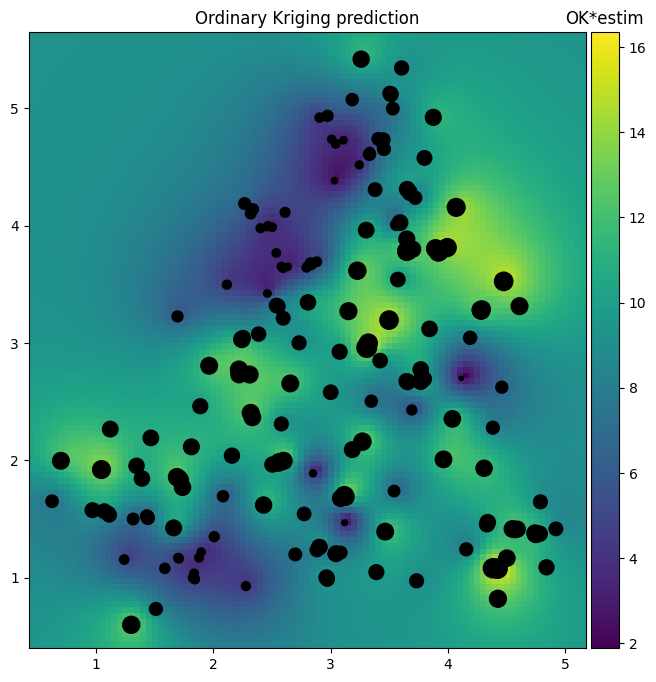

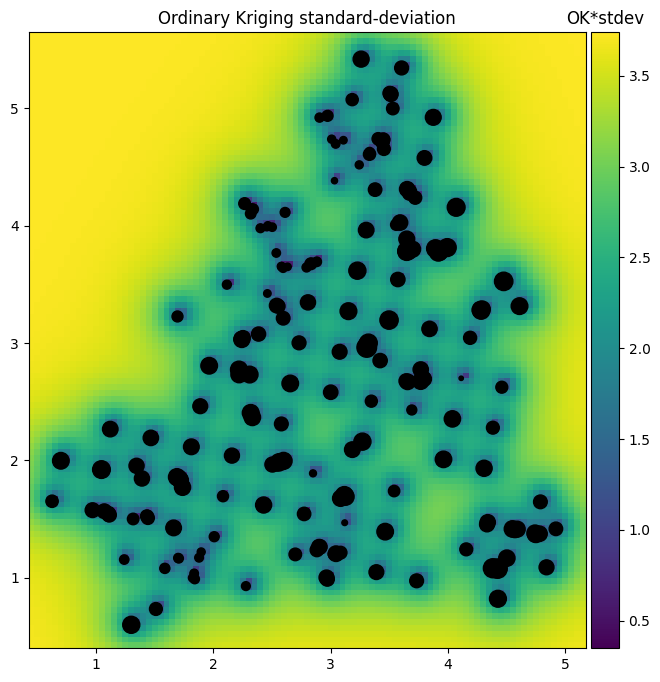

In [46]:
## Plot prediction
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="OK*estim",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Ordinary Kriging prediction")
plt.show()

## Plot kriging standard-deviation
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="OK*stdev",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Ordinary Kriging standard-deviation")
plt.show()

**Computing the ordinary kriging prediction and standard-deviation at the validation locations (instead of the target grid), and compute the resulting RMSE and MAPE.**

In [47]:
## Remove variables starting with a given prefix (-> Results from previous runs)
db_val.deleteColumns(["OK*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_val, model=model_OK, 
              neigh=uniqueNeigh,
              flag_est=True, flag_std=True, flag_varz=False, ## To compute the predictor and its standard-deviation, but not its variance
              namconv=gl.NamingConvention("OK") ## Prefix that will be used to identify the results in the output database
              )

In [48]:
## Compute RMSE
rmse_OK=np.mean((db_val["Co"]-db_val["OK*estim"])**2)**0.5
print("RMSE=",rmse_OK)

## Compute MAPE
mape_OK=np.mean(abs((db_val["Co"]-db_val["OK*estim"])/db_val["Co"]))
print("MAPE=",mape_OK)

RMSE= 2.3406004401669356
MAPE= 0.23481706338199984


### 3 - Moving neighborhoods



Up until now, we only considered kriging with a unique neighborhood. To work with a moving neighborhood, we first need to define it by creating "neighborhood" object describing its characteristics. This is done using the NeighMoving_create function. We can specify:

- a neighborhood radius (argument radius, default=1.234e30): note that the default radius value is taken very large so that the neighborhood radius can basically be seen as infinite if the argument is not set by the user
- the minimum and maximum number of data points (within the specified radius) that should be included in the neighborhood (respectively through the arguments nmini and nmaxi): for a given target point, if the number of data points within the neighborhood radius is smaller that the specified minimum, then no prediction is performed at this target (it is set to undefined)

For instance, to design a small Moving Neighborhood with only 1 sample per neighborhood (irregardless of its distance to the target point), we use the following command:


In [49]:
smallNeigh = gl.NeighMoving.create(nmini=1, nmaxi=1)



Then, (ordinary) kriging with moving neighborhood is performed using the same commands as before, but replacing the unique neighborhood in the neigh argument by our custom moving neighborhood object.


In [50]:
## Remove variables starting with a given prefix (-> Results from previous runs)
db_grid.deleteColumns(["Small*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_grid, model=model_OK, neigh=smallNeigh,
              flag_est=True, flag_std=True, 
              namconv=gl.NamingConvention("Small"))


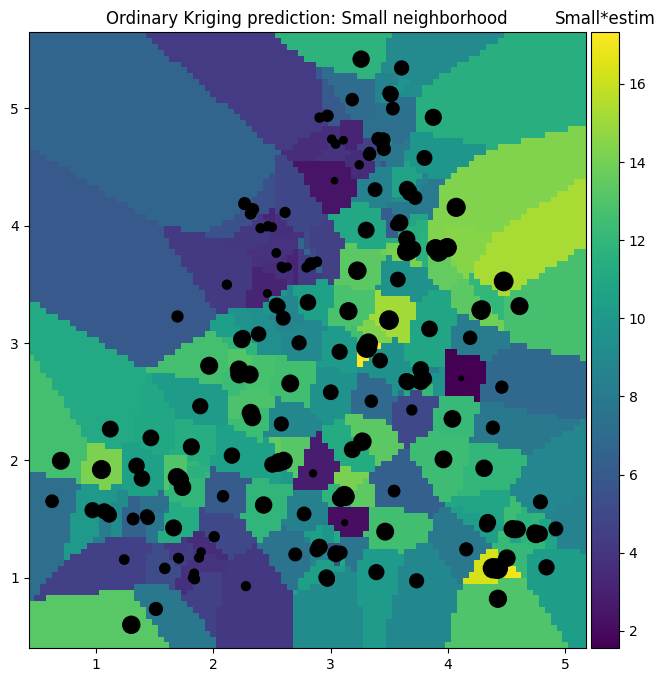

In [51]:

## Plot prediction
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="Small*estim",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Ordinary Kriging prediction: Small neighborhood")
plt.show()



**Create a moving neighborhood with radius 2 and containing between 1 and 20 points, and use it to perform an ordinary kriging prediction of Cobalt concentrations on the target grid. (Hint: Use the prefix "Large" to store the kriging results)**


In [52]:
## Create moving neighborhood
movingNeigh = gl.NeighMoving.create(nmini=1, nmaxi=20, radius=2)

## Remove variables starting with a given prefix (-> Results from previous runs)
db_grid.deleteColumns(["Large*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_grid, model=model_OK, neigh=movingNeigh,
              flag_est=True, flag_std=True, 
              namconv=gl.NamingConvention("Large"))

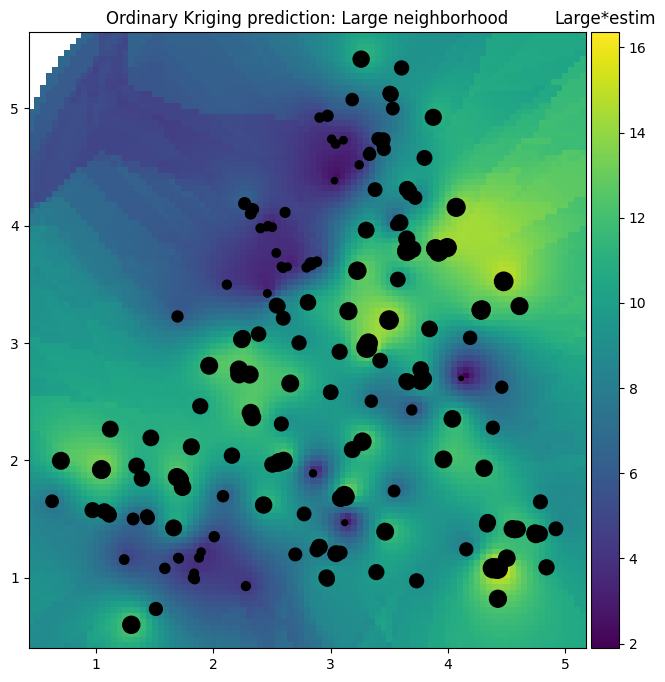

In [53]:
## Plot prediction
fig, ax = gp.initGeographic()
ax.raster(db_grid, name="Large*estim",flagLegend=True)
ax.symbol(db_jura, c='black')
ax.decoration(title="Ordinary Kriging prediction: Large neighborhood")
plt.show()

**Compute the ordinary kriging predictions at the validation locations using the same moving neighborhood, and  compute the resulting RMSE and MAPE. (Hint: Use the prefix "MvNeigh" to store the kriging results)**

In [54]:
## Remove variables starting with a given prefix (-> Results from previous runs)
db_val.deleteColumns(["MvNeigh*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_val, model=model_OK, 
              neigh=movingNeigh,
              flag_est=True, flag_std=True, flag_varz=False, ## To compute the predictor and its standard-deviation, but not its variance
              namconv=gl.NamingConvention("MvNeigh") ## Prefix that will be used to identify the results in the output database
              )

In [55]:
## Compute RMSE
rmse_OK_MN=np.mean((db_val["Co"]-db_val["MvNeigh*estim"])**2)**0.5
print("RMSE=",rmse_OK_MN)

## Compute MAPE
mape_OK_MN=np.mean(abs((db_val["Co"]-db_val["MvNeigh*estim"])/db_val["Co"]))
print("MAPE=",mape_OK_MN)


RMSE= 2.408711700803006
MAPE= 0.23913431424212342


#### **Now it's your turn! Try out different neighborhoods, models, types of kriging and try to imporve the RMSE!**

# II - Multivariate Models and Cokriging using gstlearn

To create and work with multivariate models, we simply need to work with `Db` objects containing more than one variable with a `z` locator. All the variables with a `z` locator will be considered as part of the multivariate model. Then, the same commands as in the univariate case can be used to create and fit experimental variograms, and to perform (co)kriging predictions. 

Let us illustrate our point with our running example. We would like now to consider a multivariate model for Cobalt (Co) and Lead (Pb) concentrations. To do so, we simply allocate, in the observation data base conatining the data `db_jura`, a 'z' locator to all these variables using the `setLocators`  method.

In [56]:
## Set locators 
db_jura.setLocators(["Co","Pb"],gl.ELoc.Z,cleanSameLocator=True) # -> Role = Variable of interest

## Display content
db_jura.display()


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 11
Total number of samples      = 200

Variables
---------
Column = 0 - Name = Xloc - Locator = x1
Column = 1 - Name = Yloc - Locator = x2
Column = 2 - Name = Landuse - Locator = NA
Column = 3 - Name = Rock - Locator = NA
Column = 4 - Name = Cd - Locator = NA
Column = 5 - Name = Co - Locator = z1
Column = 6 - Name = Cr - Locator = NA
Column = 7 - Name = Cu - Locator = NA
Column = 8 - Name = Ni - Locator = NA
Column = 9 - Name = Pb - Locator = z2
Column = 10 - Name = Zn - Locator = NA


## II.1 - Fitting a multivariate model

To create experimental (directional) variograms and cross-variograms, we use the same commands as in the univariate case: since the data base `db_jura` now contains three variables with a `z` locator, the `compute` method automatically computes both variograms and cross-variograms for these variables.

In [57]:
## Create experimental variogram parametrization: 4 directions, 40 lags of size 0.05
varioParamMulti = gl.VarioParam.createMultiple(ndir=4,npas=40, dpas=0.05, toldis=0.5)

## Create experimental variogram object, and compute it from the data
varioexp2var = gl.Vario.create(varioParamMulti)
err = varioexp2var.compute(db_jura)

We can then plot the experimental variograms and cross-variograms with a simple command: the plot in the i-th row and j-th column corresponds to the cross-variogram between the variables with locators `zi` and `zj` (hence the diagonal plots correspond to the variograms of each variable).

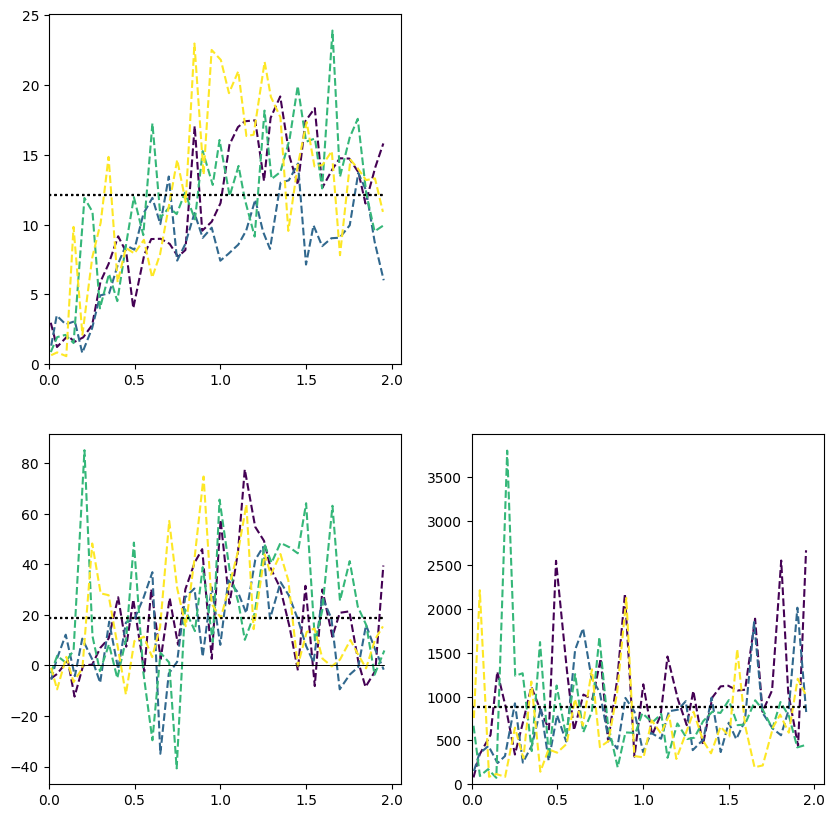

In [58]:
## Plot experimental variograms
ax=gp.varmod(varioexp2var)

To fit a model on the experimental variograms and cross-variograms, we use the same commands as in the univariate case. For instance, to fit a model containing two basic structures, a nugget effet (`gl.ECov.NUGGET`) and a spherical covariance (`gl.ECov.SPHERICAL`), we use the following command.

In [61]:
## Fit model on experimental cross-variograms
fitmod2var = gl.Model()
err = fitmod2var.fit(varioexp2var,
                     types=[gl.ECov.NUGGET, gl.ECov.SPHERICAL])

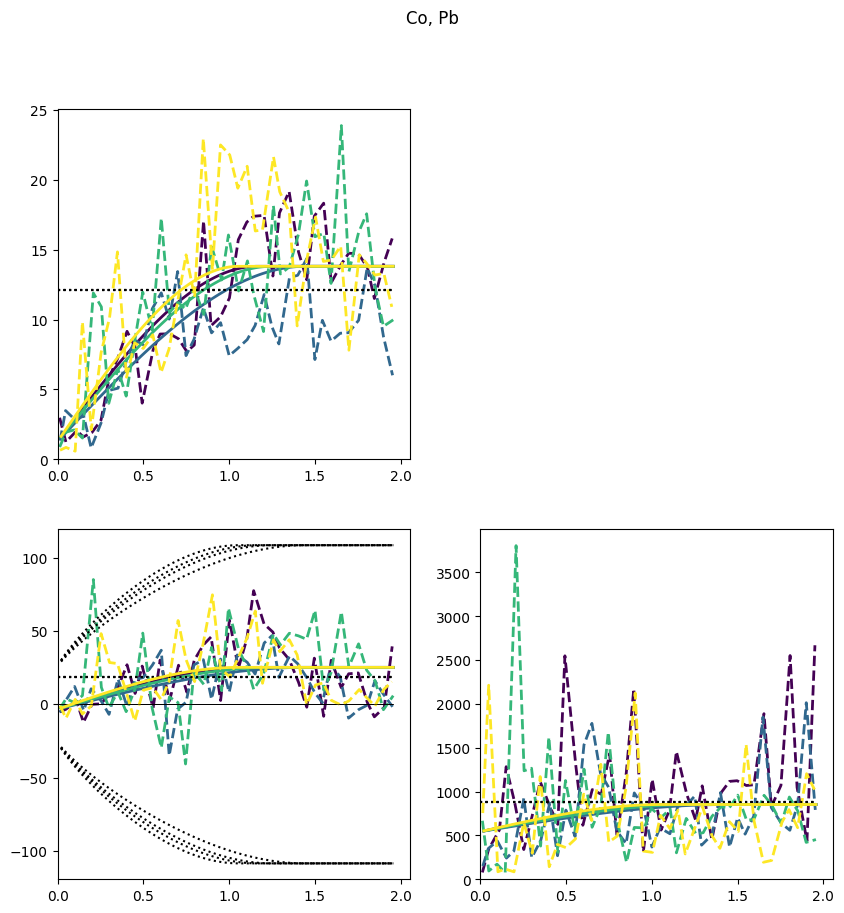

In [60]:
## Plot
ax = gp.varmod(varioexp2var, fitmod2var, lw=2)
gp.decoration(ax,title="Co, Pb")

**Compute the experimental cross-variograms for the variables "Co", "Cu" and "Zn" and fit a model containing three basic structures a Nugget effet (`gl.ECov.NUGGET`), an exponential covariance (`gl.ECov.EXPONENTIAL`) and a cubic covariance (`gl.ECov.CUBIC`).**

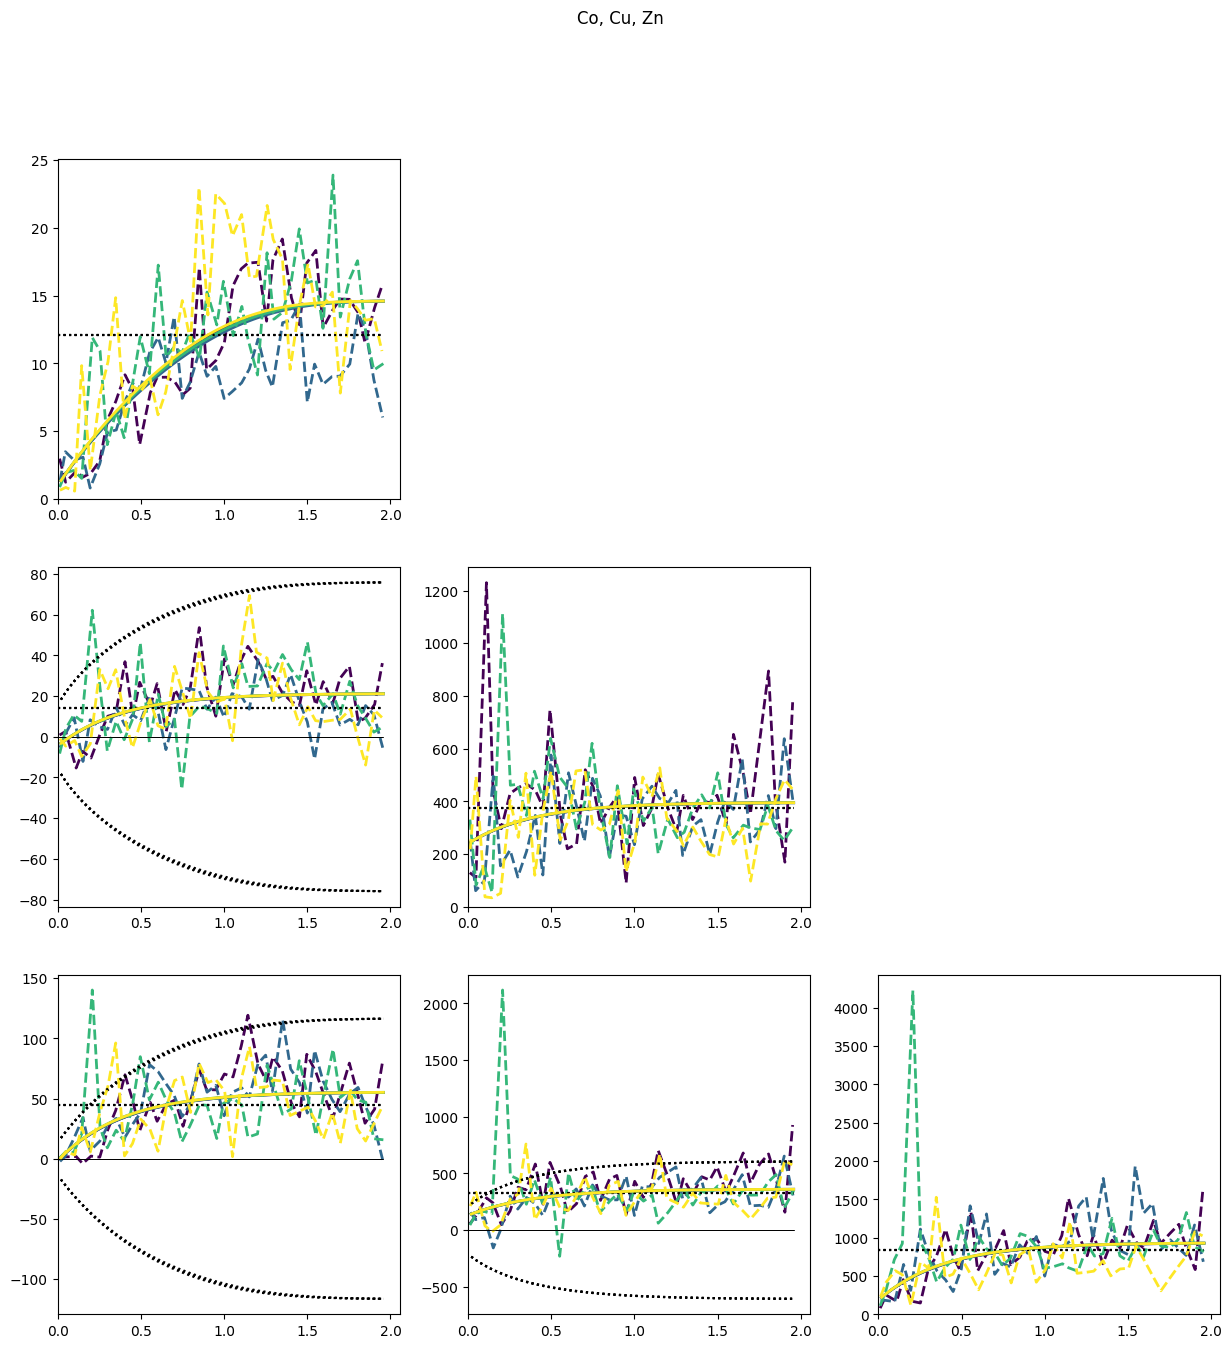

In [62]:
## Set locators 
db_jura.setLocators(["Co", "Cu","Zn"],gl.ELoc.Z,cleanSameLocator=True) # -> Role = Variable of interest

## Create experimental variogram parametrization: 4 directions, 40 lags of size 0.05
varioParamMulti = gl.VarioParam.createMultiple(ndir=4,npas=40, dpas=0.05, toldis=0.5)

## Create experimental variogram object, and compute it from the data
varioexp3var = gl.Vario.create(varioParamMulti)
err = varioexp3var.compute(db_jura)

## Fit model on experimental cross-variograms
fitmod3var = gl.Model()
err = fitmod3var.fit(varioexp3var,
                     types=[gl.ECov.NUGGET, gl.ECov.EXPONENTIAL, gl.ECov.CUBIC])

## Plot
ax = gp.varmod(varioexp3var, fitmod3var, lw=2)
gp.decoration(ax,title="Co, Cu, Zn")

## II.2 - Cokriging predictions

To compute predictions by (ordinary) cokriging on the grid, we use the same syntax as in univariate case: a predictor for each variable in the multivariate model is produced. (Note: we revert back to a unique neighborhood to compare with the predictors previously introduced).

In [63]:
## Copy the covariance model previously fitted on the data 
model_COK=gl.Model(fitmod3var)
## Add universality condition
model_COK.addDrift(gl.DriftM())
## Display content
model_COK.display()


Model characteristics
Space dimension              = 2
Number of variable(s)        = 3
Number of basic structure(s) = 3
Number of drift function(s)  = 1
Number of drift equation(s)  = 3

Covariance Part
---------------
Nugget Effect
- Sill matrix:
               [,  0]    [,  1]    [,  2]
     [  0,]     0.997    -4.481    -1.632
     [  1,]    -4.481   239.390   130.966
     [  2,]    -1.632   130.966   184.453
Exponential
- Sill matrix:
               [,  0]    [,  1]    [,  2]
     [  0,]     7.293    25.774    57.024
     [  1,]    25.774   156.317   231.131
     [  2,]    57.024   231.131   748.412
- Ranges       =      1.161     1.206
- Theo. Ranges =      0.388     0.403
- Angles       =    112.282     0.000
- Rotation Matrix
               [,  0]    [,  1]
     [  0,]     0.379     0.925
     [  1,]    -0.925     0.379
Cubic
- Sill matrix:
               [,  0]    [,  1]    [,  2]
     [  0,]     6.356     0.027     0.176
     [  1,]     0.027     0.000     0.001
     [  2,] 

In [64]:
## Remove variables starting with a given prefix (-> Results from previous runs)
db_grid.deleteColumns(["COK*"])

## Compute cokriging
err = gl.kriging(dbin=db_jura, dbout=db_grid, model=fitmod3var, 
                neigh=uniqueNeigh,
                namconv=gl.NamingConvention.create(prefix="COK"))

db_grid.display()


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 16
Total number of samples      = 9975

Grid characteristics:
---------------------
Origin :      0.426     0.399
Mesh   :      0.050     0.050
Number :         95       105

Variables
---------
Column = 0 - Name = x1 - Locator = x1
Column = 1 - Name = x2 - Locator = x2
Column = 2 - Name = SK.Co.estim - Locator = NA
Column = 3 - Name = SK.Co.stdev - Locator = NA
Column = 4 - Name = OK.Co.estim - Locator = NA
Column = 5 - Name = OK.Co.stdev - Locator = NA
Column = 6 - Name = Small.Co.estim - Locator = NA
Column = 7 - Name = Small.Co.stdev - Locator = NA
Column = 8 - Name = Large.Co.estim - Locator = NA
Column = 9 - Name = Large.Co.stdev - Locator = NA
Column = 10 - Name = COK.Co.estim - Locator = z1
Column = 11 - Name = COK.Cu.estim - Locator = z2
Column = 12 - Name = COK.Zn.estim - Locator = z3
Column = 13 - Name = COK.

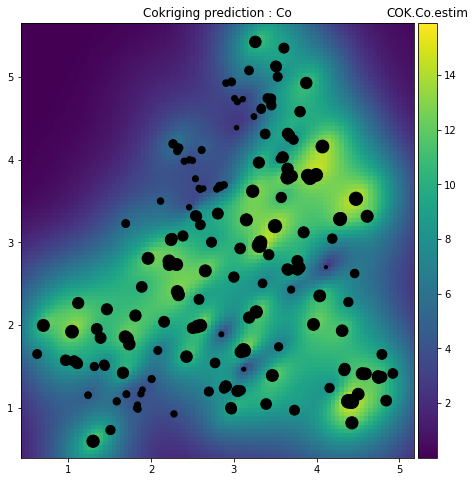

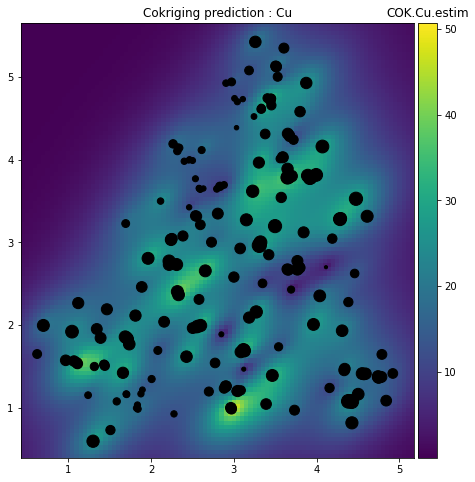

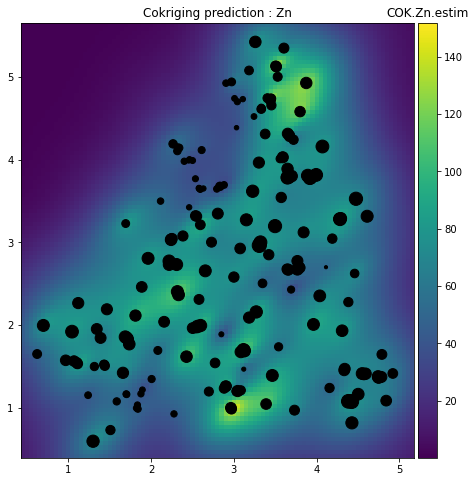

In [249]:
## Plot predictions
for metal_name in ['Co','Cu','Zn']:
    fig, ax = gp.initGeographic()
    ax.raster(db_grid, name="COK."+metal_name+".estim",flagLegend=True)
    ax.symbol(db_jura, c='black')
    ax.decoration(title="Cokriging prediction : " +metal_name)
    plt.show()


**Compute the ordinary co-kriging predictions at the validation locations using a unique neighborhood and compute the resulting RMSE and MAPE. (Hint: Use the prefix "COK" to store the results)**

In [250]:
## Remove variables starting with a given prefix (-> Results from previous runs)
db_val.deleteColumns(["COK*"])

## Compute kriging
err = gl.kriging(dbin=db_jura, dbout=db_val, model=fitmod3var, 
                neigh=uniqueNeigh,
                namconv=gl.NamingConvention.create(prefix="COK"))

## Compute RMSE
rmse_COK=np.mean((db_val["Co"]-db_val["COK.Co.estim"])**2)**0.5
print("RMSE=",rmse_COK)

## Compute MAPE
mape_COK=np.mean(abs((db_val["Co"]-db_val["COK.Co.estim"])/db_val["Co"]))
print("MAPE=",mape_COK)


RMSE= 2.769574930225752
MAPE= 0.2482265724739945


#### **Now it's your turn! Try out different combinations of variables, neighborhoods, models, types of kriging and try to imporve the RMSE!**